<a href="https://colab.research.google.com/github/supreethbmohan27/BrainTumorSegmentation/blob/main/BraTSNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Libraries
Importing all the necessary libraries and installing dependencies. These include tools for data handling like NumPy and Pandas, image processing libraries like NiBabel and pydicom for dealing with medical images, and deep learning frameworks such as PyTorch and Albumentations for building and training models. This setup is crucial for enabling the subsequent steps in data loading, visualization, and model training.

In [ ]:
from tqdm import tqdm
import os
import time
from random import randint

!pip install pydicom
import gc
import numpy as np
from scipy import stats
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import KFold

!pip install nibabel
import nibabel as nib
import pydicom as pdm
!pip install nilearn
import nilearn as nl
import nilearn.plotting as nlplt
import h5py

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as anim
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

import seaborn as sns
import imageio
from skimage.transform import resize
from skimage.util import montage

from IPython.display import Image as show_gif
from IPython.display import clear_output
from IPython.display import YouTubeVideo

!pip install torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import MSELoss


!pip install albumentations==0.4.6
import albumentations as A
# from albumentations.pytorch import ToTensor, ToTensorV2


from albumentations import Compose, HorizontalFlip
# from albumentations.pytorch import ToTensor, ToTensorV2

import warnings
warnings.simplefilter("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 85.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65153 sha256=4e3951867ee21bbe2181ac7780b60e5d423b7898b83afacbb5766785925bad85
  Stored in directory: /root/.cache/pip/wheels/f9/d7/0c/6ed42fd872f7d1af78b25045f8b16be330f2c70ae72c83e37d
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.20
    Uninstalling albumentations-1.4.20:
      Successfully uninstalled albumentations-1.4.20


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Code and Data Loading time

In [ ]:
# code wall time starts(cw0)
cw0 = time.time()

# data loading time starts(dl0)
dl0 = time.time()

List of the files in a sample patient folder to get a sense of the data structure

In [ ]:
sample_filename = '/content/drive/MyDrive/BraTS/BrainTumorData/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii'
sample_filename_mask = '/content/drive/MyDrive/BraTS/BrainTumorData/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii'

sample_img = nib.load(sample_filename)
sample_img = np.asanyarray(sample_img.dataobj)
sample_img = np.rot90(sample_img)
sample_mask = nib.load(sample_filename_mask)
sample_mask = np.asanyarray(sample_mask.dataobj)
sample_mask = np.rot90(sample_mask)
print("img shape ->", sample_img.shape)
print("mask shape ->", sample_mask.shape)


img shape -> (240, 240, 155)
mask shape -> (240, 240, 155)


In [ ]:
# total data loading time(dlt)
dl1 = time.time()
dlt = dl1 - dl0
print("Data loading time : ", dlt )

Data loading time :  4.190437316894531


# Sample Data
Load the MRI scans in different modalities (such as T1, T2, and FLAIR) using NiBabel. These are converted into NumPy arrays, a necessary step for manipulation, visualization, and model input preparation.

In [ ]:
sample_filename2 = '/content/drive/MyDrive/BraTS/BrainTumorData/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1.nii'
sample_img2 = nib.load(sample_filename2)
sample_img2 = np.asanyarray(sample_img2.dataobj)
sample_img2  = np.rot90(sample_img2)

sample_filename3 = '/content/drive/MyDrive/BraTS/BrainTumorData/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t2.nii'
sample_img3 = nib.load(sample_filename3)
sample_img3 = np.asanyarray(sample_img3.dataobj)
sample_img3  = np.rot90(sample_img3)

sample_filename4 = '/content/drive/MyDrive/BraTS/BrainTumorData/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1ce.nii'
sample_img4 = nib.load(sample_filename4)
sample_img4 = np.asanyarray(sample_img4.dataobj)
sample_img4  = np.rot90(sample_img4)

# WHOLE TUOMUR / ED - LABEL 2
mask_WT = sample_mask.copy()
mask_WT[mask_WT == 1] = 1
mask_WT[mask_WT == 2] = 1
mask_WT[mask_WT == 4] = 1

# NCR OR NET - LABEL 1
mask_TC = sample_mask.copy()
mask_TC[mask_TC == 1] = 1
mask_TC[mask_TC == 2] = 0
mask_TC[mask_TC == 4] = 1

# ET - LABEL 4
mask_ET = sample_mask.copy()
mask_ET[mask_ET == 1] = 0
mask_ET[mask_ET == 2] = 0
mask_ET[mask_ET == 4] = 1

# Multimodal scans
Visually compare the same slice across all MRI modalities for a given patient. This is an important diagnostic step to see how each scan type contributes different clinical information.

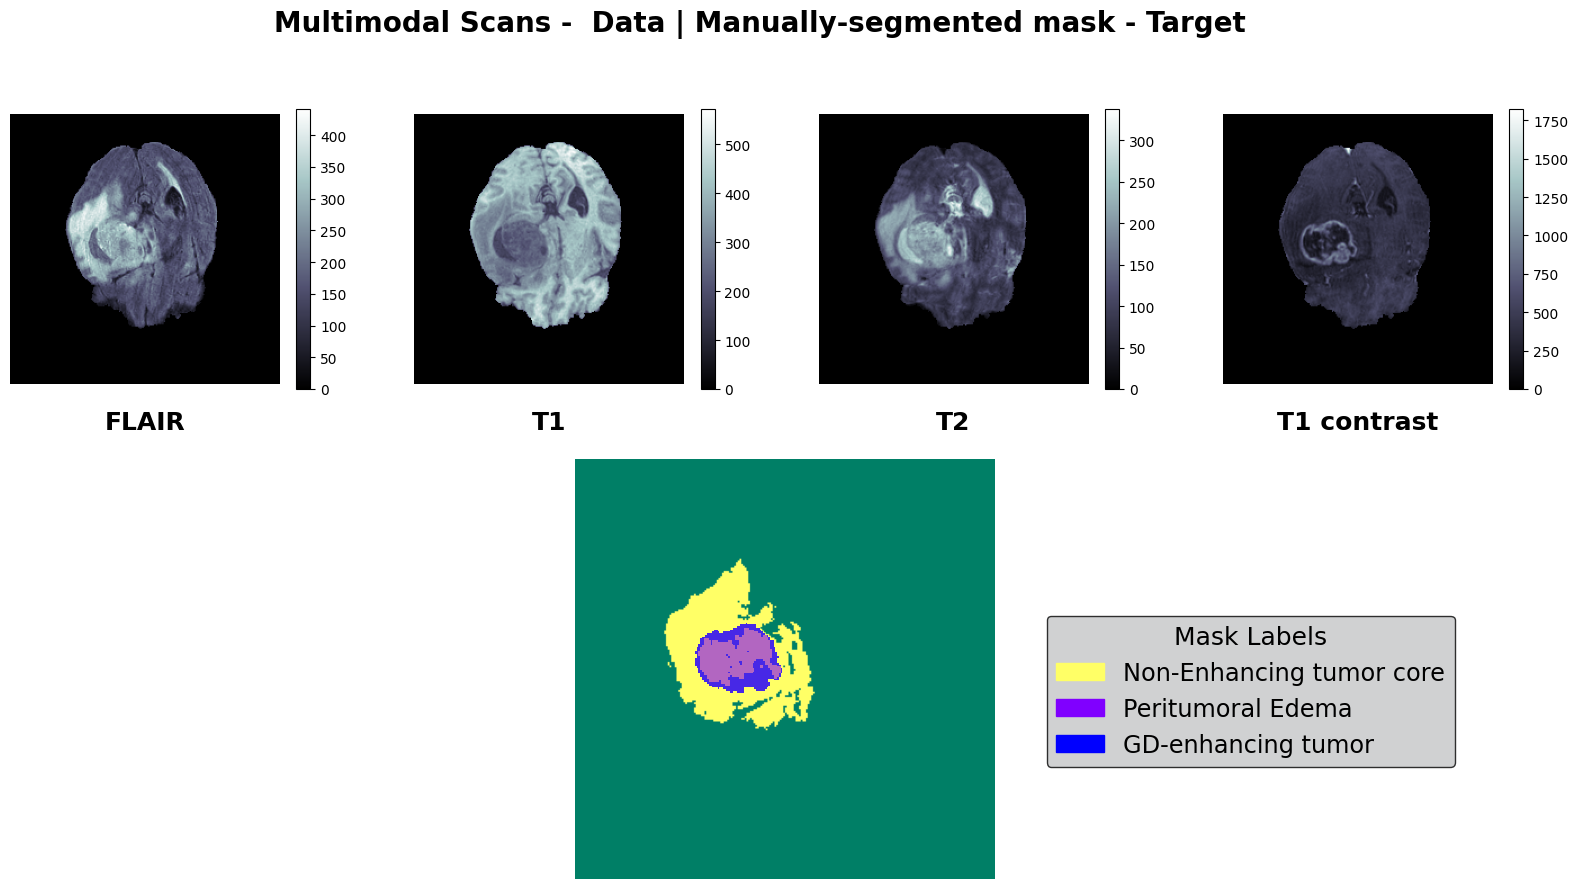

In [ ]:
fig = plt.figure(figsize=(20, 10))

gs = gridspec.GridSpec(nrows=2, ncols=4, height_ratios=[1, 1.5])

#  Varying density along a streamline
ax0 = fig.add_subplot(gs[0, 0])
flair = ax0.imshow(sample_img[:,:,65], cmap='bone')
ax0.set_title("FLAIR", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(flair)

#  Varying density along a streamline
ax1 = fig.add_subplot(gs[0, 1])
t1 = ax1.imshow(sample_img2[:,:,65], cmap='bone')
ax1.set_title("T1", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(t1)

#  Varying density along a streamline
ax2 = fig.add_subplot(gs[0, 2])
t2 = ax2.imshow(sample_img3[:,:,65], cmap='bone')
ax2.set_title("T2", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(t2)

#  Varying density along a streamline
ax3 = fig.add_subplot(gs[0, 3])
t1ce = ax3.imshow(sample_img4[:,:,65], cmap='bone')
ax3.set_title("T1 contrast", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(t1ce)

#  Varying density along a streamline
ax4 = fig.add_subplot(gs[1, 1:3])

#ax4.imshow(np.ma.masked_where(mask_WT[:,:,65]== False,  mask_WT[:,:,65]), cmap='summer', alpha=0.6)
l1 = ax4.imshow(mask_WT[:,:,65], cmap='summer',)
l2 = ax4.imshow(np.ma.masked_where(mask_TC[:,:,65]== False,  mask_TC[:,:,65]), cmap='rainbow', alpha=0.6)
l3 = ax4.imshow(np.ma.masked_where(mask_ET[:,:,65] == False, mask_ET[:,:,65]), cmap='winter', alpha=0.6)

ax4.set_title("", fontsize=20, weight='bold', y=-0.1)

_ = [ax.set_axis_off() for ax in [ax0,ax1,ax2,ax3, ax4]]

colors = [im.cmap(im.norm(1)) for im in [l1,l2, l3]]
labels = ['Non-Enhancing tumor core', 'Peritumoral Edema ', 'GD-enhancing tumor']
patches = [ mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4,fontsize = 'xx-large',
           title='Mask Labels', title_fontsize=18, edgecolor="black",  facecolor='#c5c6c7')

plt.suptitle("Multimodal Scans -  Data | Manually-segmented mask - Target", fontsize=20, weight='bold')

fig.savefig("data_sample.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
fig.savefig("data_sample.svg", format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')

# 3D Image to GIF
This class helps transform 3D medical images into visually interpretable formats for 3D plotting and GIF generation.



In [ ]:
class Image3dToGIF3d:
    """
    Displaying 3D images in 3d axes.
    Parameters:
        img_dim: shape of cube for resizing.
        figsize: figure size for plotting in inches.
    """

    #Initializes the class with parameters for image shape, figure size, and options for binary display and normalization.
    def __init__(self,
                 img_dim: tuple = (55, 55, 55),
                 figsize: tuple = (15, 10),
                 binary: bool = False,
                 normalizing: bool = True,
                ):
        """Initialization."""
        self.img_dim = img_dim
        print(img_dim)
        self.figsize = figsize
        self.binary = binary
        self.normalizing = normalizing

    #Takes a 3D (or 4D) array and creates spacing between voxels, expanding the data for more visually distinct voxel plotting.
    def _explode(self, data: np.ndarray):
        """
        Takes: array and return an array twice as large in each dimension,
        with an extra space between each voxel.
        """
        shape_arr = np.array(data.shape)
        size = shape_arr[:3] * 2 - 1
        exploded = np.zeros(np.concatenate([size, shape_arr[3:]]),
                            dtype=data.dtype)
        exploded[::2, ::2, ::2] = data
        return exploded
    # def _explode(self, data: np.ndarray):
    #     """
    #     Expands an array by adding empty spaces between elements,
    #     while maintaining the original dimensions.

    #     Parameters:
    #         data (np.ndarray): The input array, assumed to be 4D with the last dimension for color/alpha channels.

    #     Returns:
    #         np.ndarray: An expanded array with spaces between elements, but the overall shape remains consistent.
    #     """
    #     # Get original shape and compute expanded size
    #     shape_arr = np.array(data.shape)
    #     expanded_size = shape_arr[:3] * 2 - 1

    #     # Initialize the expanded array
    #     exploded = np.zeros(np.concatenate([expanded_size, shape_arr[3:]]), dtype=data.dtype)

    #     # Populate the new array without changing overall shape
    #     exploded[::2, ::2, ::2] = data

    #     # If dimensions mismatch, add padding to retain original shape
    #     if exploded.shape != data.shape:
    #         padding = [(0, max(0, data.shape[i] - exploded.shape[i])) for i in range(3)] + [(0, 0)]
    #         exploded = np.pad(exploded, padding, mode='constant', constant_values=0)

    #     return exploded

    #Shifts coordinates in 3D space so that exploded voxels are properly spaced in the visual representation.
    def _expand_coordinates(self, indices: np.ndarray):
        x, y, z = indices
        x[1::2, :, :] += 1
        y[:, 1::2, :] += 1
        z[:, :, 1::2] += 1
        return x, y, z

    #Scales all pixel/voxel values of the image to lie between 0 and 1, improving consistency and visual clarity.
    def _normalize(self, arr: np.ndarray):
        """Normilize image value between 0 and 1."""
        arr_min = np.min(arr)
        return (arr - arr_min) / (np.max(arr) - arr_min)

    #Adjusts contrast or intensity by centering values around the mean and scaling them — useful for highlighting details.
    def _scale_by(self, arr: np.ndarray, factor: int):
        """
        Scale 3d Image to factor.
        Parameters:
            arr: 3d image for scalling.
            factor: factor for scalling.
        """
        mean = np.mean(arr)
        return (arr - mean) * factor + mean

    #Combines normalization, contrast adjustment, and resizing in one pipeline to prepare the 3D image data for visualization.
    def get_transformed_data(self, data: np.ndarray):
        """Data transformation: normalization, scaling, resizing."""
        if self.binary:
            resized_data = resize(data, self.img_dim, preserve_range=True)
            return np.clip(resized_data.astype(np.uint8), 0, 1).astype(np.float32)

        norm_data = np.clip(self._normalize(data)-0.1, 0, 1) ** 0.4
        scaled_data = np.clip(self._scale_by(norm_data, 2) - 0.1, 0, 1)
        resized_data = resize(scaled_data, self.img_dim, preserve_range=True)

        return resized_data


    def plot_cube(self, cube, title='', init_angle=0, make_gif=True, path_to_save='output.gif'):
        """
        Plot a 3D cube and optionally create a GIF from the 3D visualization.

        Parameters:
            cube: numpy array of shape (height, width, depth)
            title: title of the plot
            init_angle: initial angle for viewing the cube
            make_gif: boolean to create a GIF
            path_to_save: file path for saving the GIF
        """
        # Validate cube shape
        if cube.ndim != 3:
            raise ValueError(f"Input cube must have 3 dimensions, but has {cube.ndim} dimensions.")

        # Normalize the cube if required
        if self.normalizing:
            cube = self._normalize(cube)

        # Create a mask for non-zero values
        filled = cube != 0
        x, y, z = np.indices(cube.shape)

        # Flatten the arrays to plot with scatter
        x = x[filled]
        y = y[filled]
        z = z[filled]
        colors = cube[filled]

        # Normalize colors for better visualization
        norm = plt.Normalize(colors.min(), colors.max())
        colors_normalized = plt.cm.viridis(norm(colors))

        with plt.style.context("dark_background"):
            fig = plt.figure(figsize=(10, 10))
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(x, y, z, c=colors_normalized, marker='o', s=10)  # Use 'o' for sphere markers
            ax.view_init(30, init_angle)
            ax.set_title(title, fontsize=18, y=1.05)

            # Create a GIF if specified
            if make_gif:
                images = []
                for angle in range(0, 360, 5):
                    ax.view_init(30, angle)
                    fname = str(angle) + '.png'

                    plt.savefig(fname, dpi=120, format='png', bbox_inches='tight')
                    images.append(imageio.imread(fname))
                    # os.remove(fname)  # Uncomment if you want to delete frames after creating GIF
                imageio.mimsave(path_to_save, images, duration=0.1)
                plt.close()
            else:
                plt.show()

#Visualizes model results by overlaying predicted tumor regions on the original brain MRI image and comparing them to ground truth.
class ShowResult:

    #Converts the tensor mask to NumPy for plotting. Rotates and arranges tumor subtypes (WT, TC, ET) into 2D montages for visualization.
    def mask_preprocessing(self, mask):
        """
        Test.
        """
        # removing all the ones in the tensor --> using cpu --> removing the tensor from its computational graph --> tensor to numpy conversion
        mask = mask.squeeze().cpu().detach().numpy()
        mask = np.moveaxis(mask, (0, 1, 2, 3), (0, 3, 2, 1))

        mask_WT = np.rot90(montage(mask[0]))
        mask_TC = np.rot90(montage(mask[1]))
        mask_ET = np.rot90(montage(mask[2]))

        return mask_WT, mask_TC, mask_ET

    #Extracts and formats the FLAIR sequence from the image tensor for use as a background in visualization.
    def image_preprocessing(self, image):
        """
        Returns image flair as mask for overlaping gt and predictions.
        """
        image = image.squeeze().cpu().detach().numpy()
        image = np.moveaxis(image, (0, 1, 2, 3), (0, 3, 2, 1))
        flair_img = np.rot90(montage(image[0]))
        return flair_img

    #Creates a side-by-side visual comparison of Ground Truth vs Prediction. Uses colored overlays for different tumor regions:

    #Cool_R → Whole Tumor

    #Autumn_R → Tumor Core

    #Autumn → Enhancing Tumor

    def plot(self, image, ground_truth, prediction):
        image = self.image_preprocessing(image)
        gt_mask_WT, gt_mask_TC, gt_mask_ET = self.mask_preprocessing(ground_truth)
        pr_mask_WT, pr_mask_TC, pr_mask_ET = self.mask_preprocessing(prediction)

        fig, axes = plt.subplots(1, 2, figsize = (35, 30))

        [ax.axis("off") for ax in axes]
        axes[0].set_title("Ground Truth", fontsize=35, weight='bold')
        axes[0].imshow(image, cmap ='bone')
        axes[0].imshow(np.ma.masked_where(gt_mask_WT == False, gt_mask_WT),
                  cmap='cool_r', alpha=0.6)
        axes[0].imshow(np.ma.masked_where(gt_mask_TC == False, gt_mask_TC),
                  cmap='autumn_r', alpha=0.6)
        axes[0].imshow(np.ma.masked_where(gt_mask_ET == False, gt_mask_ET),
                  cmap='autumn', alpha=0.6)

        axes[1].set_title("Prediction", fontsize=35, weight='bold')
        axes[1].imshow(image, cmap ='bone')
        axes[1].imshow(np.ma.masked_where(pr_mask_WT == False, pr_mask_WT),
                  cmap='cool_r', alpha=0.6)
        axes[1].imshow(np.ma.masked_where(pr_mask_TC == False, pr_mask_TC),
                  cmap='autumn_r', alpha=0.6)
        axes[1].imshow(np.ma.masked_where(pr_mask_ET == False, pr_mask_ET),
                  cmap='autumn', alpha=0.6)

        plt.tight_layout()

        plt.show()

#show_result = ShowResult()
#show_result.plot(data['image'], data['mask'], data['mask'])

#Combines two GIFs (e.g., GT and prediction) side by side into a single animation for easier comparison.
def merging_two_gif(path1: str, path2: str, name_to_save: str):
    """
    Merging GIFs side by side.
    Parameters:
        path1: path to gif with ground truth.
        path2: path to gif with prediction.
        name_to_save: name for saving new GIF.
    """
    #https://stackoverflow.com/questions/51517685/combine-several-gif-horizontally-python
    #Create reader object for the gif
    gif1 = imageio.get_reader(path1)
    gif2 = imageio.get_reader(path2)

    #If they don't have the same number of frame take the shorter
    number_of_frames = min(gif1.get_length(), gif2.get_length())

    #Create writer object
    new_gif = imageio.get_writer(name_to_save)

    for frame_number in range(number_of_frames):
        img1 = gif1.get_next_data()
        img2 = gif2.get_next_data()
        #here is the magic
        new_image = np.hstack((img1, img2))
        new_gif.append_data(new_image)

    gif1.close()
    gif2.close()
    new_gif.close()

#merging_two_gif('BraTS20_Training_001_flair_3d.gif',
#                'BraTS20_Training_001_flair_3d.gif',
#                'result.gif')

#Walks through a directory and collects paths to all .csv files — used for dataset or report processing.
def get_all_csv_file(root: str) -> list:
    """Extraction all unique ids from file names."""
    ids = []
    for dirname, _, filenames in os.walk(root):
        for filename in filenames:
            path = os.path.join(dirname, filename)
            if path.endswith(".csv"):
                ids.append(path)
    ids = list(set(filter(None, ids)))
    print(f"Extracted {len(ids)} csv files.")
    return ids

#csv_paths = get_all_csv_file("../input/brats20-dataset-training-validation/BraTS2020_TrainingData")

# Configuration

In [ ]:
#Centralized configuration for paths and parameters used throughout the brain tumor detection pipeline.
class GlobalConfig:
    root_dir = '/content/drive/MyDrive/BraTS/BrainTumorData/'
    train_root_dir = '/content/drive/MyDrive/BraTS/BrainTumorData/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
    test_root_dir = '/content/drive/MyDrive/BraTS/BrainTumorData/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'
    path_to_csv = '/content/drive/MyDrive/BraTS/BrainTumorData/train_data.csv'
    pretrained_model_path = '/content/drive/MyDrive/BraTS/BrainTumorData/brats2020logs/unet/last_epoch_model.pth'
    train_logs_path = '/content/drive/MyDrive/BraTS/BrainTumorData/brats2020logs/unet/train_log.csv'
    ae_pretrained_model_path = '/content/drive/MyDrive/BraTS/BrainTumorData/brats2020logs/ae/autoencoder_best_model.pth'
    tab_data = 'E:/BraTS/BrainTumorData/brats2020logs/data/df_with_voxel_stats_and_latent_features.csv'
    seed = 55

#Ensures consistent results across runs by fixing random seeds.
def seed_everything(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

config = GlobalConfig()
seed_everything(config.seed)

In [ ]:
# data pre-processing time starts(dpp0)
dpp0 = time.time()

In [ ]:
#Merged survival data with paths, removed null-age entries, stratified by age bins, and excluded outlier BraTS20_Training_355.
survival_info_df = pd.read_csv('/content/drive/MyDrive/BraTS/BrainTumorData/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/survival_info.csv')
name_mapping_df = pd.read_csv('/content/drive/MyDrive/BraTS/BrainTumorData/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/name_mapping.csv')

name_mapping_df.rename({'BraTS_2020_subject_ID': 'Brats20ID'}, axis=1, inplace=True)


df = survival_info_df.merge(name_mapping_df, on="Brats20ID", how="right")

# renaming & merging into one dataframe
paths = []
for _, row  in df.iterrows():

    id_ = row['Brats20ID']
    phase = id_.split("_")[-2]
    if phase == 'Training':
        path = os.path.join(config.train_root_dir, id_)
    else:
        path = os.path.join(config.test_root_dir, id_)
    paths.append(path)

df['path'] = paths

# config.train_root_dir = "/data/training"
# id_ = "BraTS20_Training_001"
# path = os.path.join(config.train_root_dir, id_)
# output ==> path = /data/training/BraTS20_Training_001

#split data on train, test, split
#train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=69, shuffle=True)
#train_df, val_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True)
# Data cleaning - removing all null age entries
train_data = df.loc[df['Age'].notnull()].reset_index(drop=True)

# Calculating Age rank for the basis of K - Fold stratification
train_data["Age_rank"] =  train_data["Age"] // 10 * 10
train_data = train_data.loc[train_data['Brats20ID'] != 'BraTS20_Training_355'].reset_index(drop=True, )

len(df)

369

In [ ]:
# stratified k-fold ( skf ) time starts
skf0 = time.time()

In [ ]:
#Performed 7-fold stratification on age ranks, assigned folds, split into train_df, val_df, and test_df, and saved all CSVs.
skf = StratifiedKFold(
    n_splits=7, random_state=config.seed, shuffle=True
)

# enumeratng all entries for defining the fold number
# assigning the fold number in increment order
for i, (train_index, val_index) in enumerate(
        skf.split(train_data, train_data["Age_rank"])
        ):
        train_data.loc[val_index, "fold"] = i
# total stratification time(skft)
skf1 = time.time()
skft = skf1 - skf0
print("Stratification time : ",skft )

# splitting of the data wasn't done for train , test &  validation data
train_df = train_data.loc[train_data['fold'] != 0].reset_index(drop=True)
val_df = train_data.loc[train_data['fold'] == 0].reset_index(drop=True)

# selecting the rows where the AGE col. is null --> test_df
test_df = df.loc[~df['Age'].notnull()].reset_index(drop=True)
print("train_df ->", train_df.shape, "val_df ->", val_df.shape, "test_df ->", test_df.shape)

# total data pre-processing time(dppt)
dpp1 = time.time()
dppt = dpp1 - dpp0 - skft
print("Data preprocessing time : ", dppt  )

train_data.to_csv("/content/drive/MyDrive/BraTS/BrainTumorData/train_data.csv", index=False)
test_df.to_csv("/content/drive/MyDrive/BraTS/BrainTumorData/test_df.csv", index=False)
train_df.to_csv("/content/drive/MyDrive/BraTS/BrainTumorData/train_df.csv", index=False)

Stratification time :  11.758384227752686
train_df -> (201, 12) val_df -> (34, 12) test_df -> (133, 10)
Data preprocessing time :  -8.783734798431396


In [ ]:
#Custom dataset class to load a single data point (a 3D MRI volume + mask) from the DataFrame at a time.
class BratsDataset(Dataset):

    #Initializes dataset with dataframe, phase (train, valid, test), resizing option, and MRI modalities.
    def __init__(self, df: pd.DataFrame, phase: str="test", is_resize: bool=False):
        self.df = df
        self.phase = phase
        self.augmentations = get_augmentations(phase)
        self.data_types = ['_flair.nii', '_t1.nii', '_t1ce.nii', '_t2.nii']
        self.is_resize = is_resize

    #Returns the total number of samples (rows) in the dataframe.
    def __len__(self):
        return self.df.shape[0]

    #Loads MRI modalities and corresponding mask (if applicable), processes and augments them, then returns them as tensors.
    def __getitem__(self, idx):
        # at a specified index ( idx ) select the value under 'Brats20ID' & asssign it to id_
        id_ = self.df.loc[idx, 'Brats20ID']

        # As we've got the id_ , now find the path of the entry by asserting the Brats20ID to id_
        root_path = self.df.loc[self.df['Brats20ID'] == id_]['path'].values[0]

        # load all modalities
        images = []

        for data_type in self.data_types:
            # here data_type is appended to the root path, as it only contains the name without the datatype such as .nii etc
            img_path = os.path.join(root_path, id_ + data_type)
            img = self.load_img(img_path)#.transpose(2, 0, 1)

            if self.is_resize:
                img = self.resize(img)

            img = self.normalize(img)
            images.append(img)

        # stacking all the t1 , t1ce , t2 , t2 flair files of a single ID in a stack
        img = np.stack(images)
        img = np.moveaxis(img, (0, 1, 2, 3), (0, 3, 2, 1))

        if self.phase != "test":
            mask_path =  os.path.join(root_path, id_ + "_seg.nii")
            mask = self.load_img(mask_path)

            if self.is_resize:
                mask = self.resize(mask)
                # mask --> conversion to uint8 --> normalization / clipping ( 0 to 1 ) --> conversion to float32
                mask = np.clip(mask.astype(np.uint8), 0, 1).astype(np.float32)
                # again clipping ( 0 to 1 )
                mask = np.clip(mask, 0, 1)

            # setting the mask labels 1 , 2 , 4 for the mask file ( _seg.ii )
            mask = self.preprocess_mask_labels(mask)

            augmented = self.augmentations(image=img.astype(np.float32),
                                           mask=mask.astype(np.float32))
            # Several augmentations / transformations like flipping, rotating, padding will be applied to both the images
            img = augmented['image']
            mask = augmented['mask']


            return {
                "Id": id_,
                "image": img,
                "mask": mask,
            }

        return {
            "Id": id_,
            "image": img,
        }

    #Loads a .nii medical image file and converts it to a NumPy array.
    def load_img(self, file_path):
        data = nib.load(file_path)
        data = np.asarray(data.dataobj)
        return data

    #Scales image voxel intensities to a [0, 1] range using min-max normalization.
    def normalize(self, data: np.ndarray):
        data_min = np.min(data)
        # normalization = (each element - min element) / ( max - min )
        return (data - data_min) / (np.max(data) - data_min)

   #Resizes a 3D volume to fixed dimensions (78, 120, 120) while preserving voxel intensity.
    def resize(self, data: np.ndarray):
        data = resize(data, (78, 120, 120), preserve_range=True)
        return data

    #Generates binary masks for Whole Tumor (WT), Tumor Core (TC), and Enhancing Tumor (ET), and reshapes them for training.
    def preprocess_mask_labels(self, mask: np.ndarray):

        # whole tumour
        mask_WT = mask.copy()
        mask_WT[mask_WT == 1] = 1
        mask_WT[mask_WT == 2] = 1
        mask_WT[mask_WT == 4] = 1
        # include all tumours

        # NCR / NET - LABEL 1
        mask_TC = mask.copy()
        mask_TC[mask_TC == 1] = 1
        mask_TC[mask_TC == 2] = 0
        mask_TC[mask_TC == 4] = 1
        # exclude 2 / 4 labelled tumour

        # ET - LABEL 4
        mask_ET = mask.copy()
        mask_ET[mask_ET == 1] = 0
        mask_ET[mask_ET == 2] = 0
        mask_ET[mask_ET == 4] = 1
        # exclude 2 / 1 labelled tumour

        # ED - LABEL 2
        # mask_ED = mask.copy()
        # mask_ED[mask_ED == 1] = 0
        # mask_ED[mask_ED == 2] = 1
        # mask_ED[mask_ED == 4] = 0


        # mask = np.stack([mask_WT, mask_TC, mask_ET, mask_ED])
        mask = np.stack([mask_WT, mask_TC, mask_ET])
        mask = np.moveaxis(mask, (0, 1, 2, 3), (0, 3, 2, 1))

        return mask
def get_augmentations(phase):
    list_transforms = []

    # Does data augmentations & tranformation required for IMAGES & MASKS
    # they include cropping, padding, flipping , rotating
    list_trfms = Compose(list_transforms)
    return list_trfms


def get_dataloader(
    dataset: torch.utils.data.Dataset,
    path_to_csv: str,
    phase: str,
    fold: int = 0,
    batch_size: int = 1,
    num_workers: int = 4 ):

    '''Returns: dataloader for the model training'''
    df = pd.read_csv(path_to_csv)

    # selecting train_df to be all the entries EXCEPT the mentioned fold while calling dataloader
    train_df = df.loc[df['fold'] != fold].reset_index(drop=True)

    # selection a particluar fold while calling the get_dataloader function
    val_df = df.loc[df['fold'] == fold].reset_index(drop=True)
#     test_df = df.loc[~df['Age'].notnull()].reset_index(drop=True)
#     print(len(train_df) , len(val_df), len(test_df))


    # read csv --> train & validation df splitting --> assigning train_df / val_df to df based on phase --> returning dataloader
    # how does val_df / train_df got converted to ( id , image tensor , mask tensor )

    if phase == "train" :
        df = train_df
    elif phase == "valid" :
        df = val_df
#     else:
#         df = test_df
    dataset = dataset(df, phase)
    """
    DataLoader iteratively goes through every id in the df & gets all the individual tuples for individual ids & appends all of them
    like this :
    { id : ['BraTS20_Training_235'] ,
      image : [] ,
      tensor : [] ,
    }
    { id : ['BraTS20_Training_236'] ,
      image : [] ,
      tensor : [] ,
    }
    { id : ['BraTS20_Training_237'] ,
      image : [] ,
      tensor : [] ,
    }
    """
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers= num_workers ,
        pin_memory=True,
        shuffle=True,
    )
    return dataloader
dataloader = get_dataloader(dataset=BratsDataset, path_to_csv='/content/drive/MyDrive/BraTS/BrainTumorData/train_data.csv', phase='valid', fold=0)
len(dataloader)

34

In [ ]:
data = next(iter(dataloader))
data['Id'], data['image'].shape, data['mask'].shape


(['BraTS20_Training_162'],
 torch.Size([1, 4, 155, 240, 240]),
 torch.Size([1, 3, 155, 240, 240]))

In [ ]:
print(data['image'].shape)
print(data['mask'].shape)

torch.Size([1, 4, 155, 240, 240])
torch.Size([1, 3, 155, 240, 240])


Num uniq Image values : 398
Min/Max Image values: 0.0 1.0
Num uniq Mask values: (array([0., 1.], dtype=float32), array([8820672,  107328]))


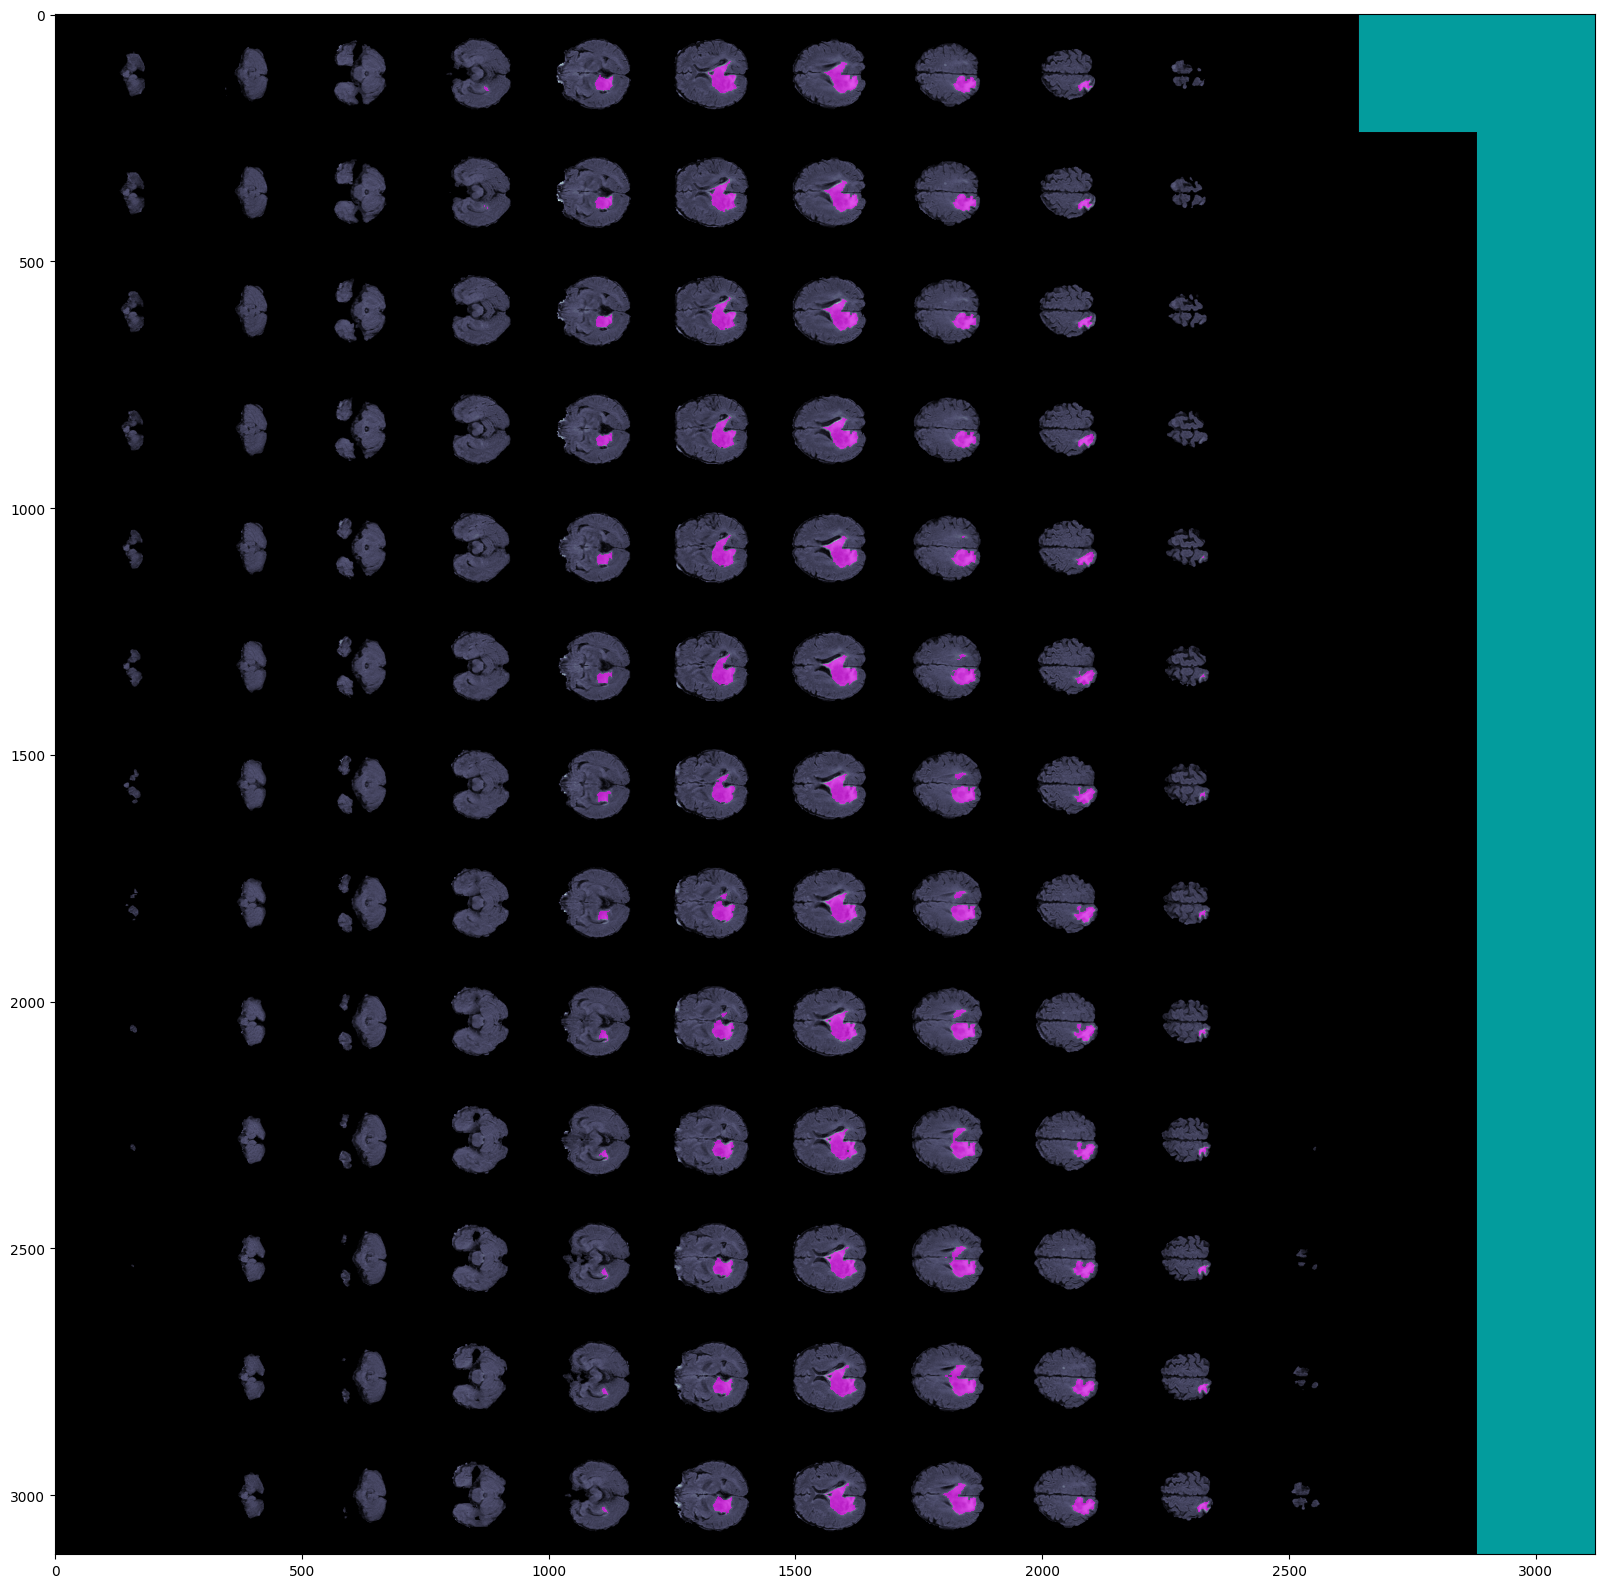

In [ ]:
# Printing all the images & masks of "FOLD 0" --> 34 batches
# 34 BATCHES of images & masks each batch containing 4 types of files t1 , t2 , t1ce , flair

img_tensor = data['image'].squeeze()[0].cpu().detach().numpy()
mask_tensor = data['mask'].squeeze()[0].squeeze().cpu().detach().numpy()

print("Num uniq Image values :", len(np.unique(img_tensor, return_counts=True)[0]))
print("Min/Max Image values:", img_tensor.min(), img_tensor.max())
print("Num uniq Mask values:", np.unique(mask_tensor, return_counts=True))

image = np.rot90(montage(img_tensor))
mask = np.rot90(montage(mask_tensor))

fig, ax = plt.subplots(1, 1, figsize = (20, 20))
ax.imshow(image, cmap ='bone')
ax.imshow(np.ma.masked_where(mask == False, mask),
           cmap='cool', alpha=0.6)

In [ ]:
img_tensor.shape
mask_tensor.shape

image = np.rot90(montage(img_tensor))
mask = np.rot90(montage(mask_tensor))

# Dice and Jaccard Coefficient Metrics
We use Dice and Jaccard coefficients to measure how well the predicted segmentation overlaps with the ground truth. Dice is more sensitive to small regions and emphasizes correct predictions, while Jaccard provides a stricter measure of overall accuracy. Using both gives a balanced evaluation of our model’s performance.

In [ ]:
#Calculates the Dice coefficient (F1 score) for a batch of predicted and truth values.
def dice_coef_metric(probabilities: torch.Tensor,
                     truth: torch.Tensor,
                     treshold: float = 0.5,
                     eps: float = 1e-9) -> np.ndarray:

    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= treshold).float()
    assert(predictions.shape == truth.shape)
    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = 2.0 * (truth_ * prediction).sum()
        union = truth_.sum() + prediction.sum()
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)

#Computes the Jaccard index (Intersection over Union) for a batch of predicted and truth values.
def jaccard_coef_metric(probabilities: torch.Tensor,
               truth: torch.Tensor,
               treshold: float = 0.5,
               eps: float = 1e-9) -> np.ndarray:

    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= treshold).float()
    assert(predictions.shape == truth.shape)

    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = (prediction * truth_).sum()
        union = (prediction.sum() + truth_.sum()) - intersection + eps
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)


class Meter:
    '''factory for storing and updating iou and dice scores.'''
    def __init__(self, treshold: float = 0.5):
        self.threshold: float = treshold
        self.dice_scores: list = []
        self.iou_scores: list = []

    #update: Updates Dice and IoU scores for a batch of predictions and targets.
    def update(self, logits: torch.Tensor, targets: torch.Tensor):

        probs = torch.sigmoid(logits)
        dice = dice_coef_metric(probs, targets, self.threshold)
        iou = jaccard_coef_metric(probs, targets, self.threshold)

        # appending to the respective lists
        self.dice_scores.append(dice)
        self.iou_scores.append(iou)

    #Returns the average Dice and IoU scores.
    def get_metrics(self) -> np.ndarray:
        """
        Returns: the average of the accumulated dice and iou scores.
        """
        dice = np.mean(self.dice_scores)
        iou = np.mean(self.iou_scores)
        return dice, iou

#Computes the Dice loss between predicted logits and true targets.
class DiceLoss(nn.Module):
    """Calculate dice loss."""
    def __init__(self, eps: float = 1e-9):
        super(DiceLoss, self).__init__()
        self.eps = eps

    def forward(self,
                logits: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:

        num = targets.size(0)
        probability = torch.sigmoid(logits)
        probability = probability.view(num, -1)
        targets = targets.view(num, -1)
        assert(probability.shape == targets.shape)

        intersection = 2.0 * (probability * targets).sum()
        union = probability.sum() + targets.sum()
        dice_score = (intersection + self.eps) / union
        #print("intersection", intersection, union, dice_score)
        return 1.0 - dice_score

#Calculates the combined loss of Binary Cross-Entropy and Dice loss.
class BCEDiceLoss(nn.Module):
    """Compute objective loss: BCE loss + DICE loss."""
    def __init__(self):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()

    def forward(self,
                logits: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:

        # logits are the images
        # target are the masks
        assert(logits.shape == targets.shape)
        dice_loss = self.dice(logits, targets)
        bce_loss = self.bce(logits, targets)

        # binary cross entropy loss & dice loss
        return bce_loss + dice_loss

# helper functions for testing.
#Calculates the Dice score per class for a batch of predictions and truth values.
def dice_coef_metric_per_classes(probabilities: np.ndarray,
                                    truth: np.ndarray,
                                    treshold: float = 0.5,
                                    eps: float = 1e-9,
                                    classes: list = ['WT', 'TC', 'ET']) -> np.ndarray:

    scores = {key: list() for key in classes}
    num = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= treshold).astype(np.float32)
    assert(predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            intersection = 2.0 * (truth_ * prediction).sum()
            union = truth_.sum() + prediction.sum()
            if truth_.sum() == 0 and prediction.sum() == 0:
                 scores[classes[class_]].append(1.0)
            else:
                scores[classes[class_]].append((intersection + eps) / union)

    return scores

#Computes the Jaccard index per class for a batch of predictions and truth values.
def jaccard_coef_metric_per_classes(probabilities: np.ndarray, # output of the model in an array format
               truth: np.ndarray,# masks
               treshold: float = 0.5, # threshold to whether segment / not
               eps: float = 1e-9, # smooth
               classes: list = ['WT', 'TC', 'ET']) -> np.ndarray:

    scores = {key: list() for key in classes}
    # storing all the jaccard coefficients in a list

    num = probabilities.shape[0]

    num_classes = probabilities.shape[1]

    # segmenting if prob > threshold .i.e. setting to float32
    predictions = (probabilities >= treshold).astype(np.float32)

    assert(predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            intersection = (prediction * truth_).sum()
            union = (prediction.sum() + truth_.sum()) - intersection + eps
            if truth_.sum() == 0 and prediction.sum() == 0:
                 scores[classes[class_]].append(1.0)
            else:
                scores[classes[class_]].append((intersection + eps) / union)

    return scores

#3D UNET

In [ ]:

# 3DUnet
#Defines a block of two consecutive 3D convolution layers with batch normalization and ReLU activation.
class DoubleConv(nn.Module):
    """(Conv3D -> BN -> ReLU) * 2"""
    def __init__(self, in_channels, out_channels, num_groups=8):
        super().__init__()
        self.double_conv = nn.Sequential(
            # Convlution set one
            nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm3d(out_channels),
            nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
            nn.ReLU(inplace=True),

            # Convlution set two
            nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm3d(out_channels),
            nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
            nn.ReLU(inplace=True)

          )

    def forward(self,x):
        return self.double_conv(x)

#Defines a down-sampling layer that includes max pooling followed by a DoubleConv.
class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.MaxPool3d(2, 2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        # max pooling 3d + doubleConv
        return self.encoder(x)

#Defines an up-sampling layer that includes trilinear upsampling followed by a DoubleConv.
class Up(nn.Module):

    def __init__(self, in_channels, out_channels, trilinear=True):
        super().__init__()

        if trilinear:
            self.up = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose3d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        diffZ = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        diffX = x2.size()[4] - x1.size()[4]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2, diffZ // 2, diffZ - diffZ // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

#Defines the output layer, which applies a 1x1 convolution to produce final class predictions.
class Out(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size = 1)

    def forward(self, x):
        return self.conv(x)

#Implements a 3D U-Net architecture for semantic segmentation, combining encoding and decoding layers.
class UNet3d(nn.Module):
    def __init__(self, in_channels, n_classes, n_channels):
        super().__init__()
        self.in_channels = in_channels
        self.n_classes = n_classes
        self.n_channels = n_channels

        # extracting the features by incrementally multiplying the no.of channels
        self.conv = DoubleConv(in_channels, n_channels)
        self.enc1 = Down(n_channels, 2 * n_channels)
        self.enc2 = Down(2 * n_channels, 4 * n_channels)
        self.enc3 = Down(4 * n_channels, 8 * n_channels)
        self.enc4 = Down(8 * n_channels, 8 * n_channels)

        self.dec1 = Up(16 * n_channels, 4 * n_channels)
        self.dec2 = Up(8 * n_channels, 2 * n_channels)
        self.dec3 = Up(4 * n_channels, n_channels)
        self.dec4 = Up(2 * n_channels, n_channels)
        self.out = Out(n_channels, n_classes)

    def forward(self, x):
        x1 = self.conv(x)
        x2 = self.enc1(x1)
        x3 = self.enc2(x2)
        x4 = self.enc3(x3)
        x5 = self.enc4(x4)

        mask = self.dec1(x5, x4)
        mask = self.dec2(mask, x3)
        mask = self.dec3(mask, x2)
        mask = self.dec4(mask, x1)
        mask = self.out(mask)

        """
        After a series of either Upsampling / 3d Transpose
        a segmented image of the input image is generated
        & returned
        """
        return mask


# Trainer
#A factory for the training process, including data loading, loss calculation, and metric tracking during training.
class Trainer:
    """
    Factory for training proccess.
    Args:
        display_plot: if True - plot train history after each epoch.
        net: neural network for mask prediction.
        criterion: factory for calculating objective loss. i.e. bce loss + dice loss / others
        optimizer: optimizer for weights updating. i.e. Adam
        phases: list with train and validation phases.
        dataloaders: dict with data loaders for train and val phases. i.e. DataLoader / dataloader
        path_to_csv: path to csv file.
        meter: factory for storing and updating metrics. -> return the jaccard coeff / dice loss
        batch_size: data batch size for one step weights updating.
        num_epochs: num weights updation for all data.
        accumulation_steps: the number of steps after which the optimization step can be taken.
        lr: learning rate for optimizer.
        scheduler: scheduler for control learning rate.
        losses: dict for storing lists with losses for each phase.
        jaccard_scores: dict for storing lists with jaccard scores for each phase.
        dice_scores: dict for storing lists with dice scores for each phase.
    """
    def __init__(self,
                 net: nn.Module,
                 dataset: torch.utils.data.Dataset,
                 criterion: nn.Module,
                 lr: float,
                 accumulation_steps: int,
                 batch_size: int,
                 fold: int,
                 num_epochs: int,
                 path_to_csv: str,
                 display_plot: bool = True,
                ):

        """Initialization."""
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print("device:", self.device)
        self.display_plot = display_plot
        self.net = net
        self.net = self.net.to(self.device)
        self.criterion = criterion
        self.optimizer = Adam(self.net.parameters(), lr=lr)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min",
                                           patience=2, verbose=True)
        self.accumulation_steps = accumulation_steps // batch_size
        self.phases = ["train", "val"]
        self.num_epochs = num_epochs

        self.dataloaders = {
            phase: get_dataloader(
                dataset = dataset,
                path_to_csv = path_to_csv,
                phase = phase,
                fold = fold,
                batch_size = batch_size,
                num_workers = 4
            )
            for phase in self.phases
        }
        self.best_loss = float("inf")

        # calculating the list of losses for both train & validation phases
        self.losses = {phase: [] for phase in self.phases}

        # calculating the dice scores for both train & validation phases
        self.dice_scores = {phase: [] for phase in self.phases}

        # calculating the jaccard scores for both train & validation phases
        self.jaccard_scores = {phase: [] for phase in self.phases}

    def _compute_loss_and_outputs(self,
                                  images: torch.Tensor,
                                  targets: torch.Tensor):
        images = images.to(self.device)
        targets = targets.to(self.device)

        # making images predictions symmetric using logits
        logits = self.net(images)

        # calculating the loss bce loss / dice loss / jaccard loss / combined loss
        # as defined calcluating the mean square error loss
        loss = self.criterion(logits, targets)
        return loss, logits

    def _do_epoch(self, epoch: int, phase: str):
        print(f"{phase} epoch: {epoch} | time: {time.strftime('%H:%M:%S')}")

        self.net.train() if phase == "train" else self.net.eval()
        meter = Meter()
        dataloader = self.dataloaders[phase]
        total_batches = len(dataloader)
        running_loss = 0.0
        self.optimizer.zero_grad()
        for itr, data_batch in enumerate(dataloader):
            images, targets = data_batch['image'], data_batch['mask']
            # BCEDiceLoss & raw prediction( logits ) are calculated
            loss, logits = self._compute_loss_and_outputs(images, targets)
            loss = loss / self.accumulation_steps
            if phase == "train":
                # Backpropagating the losses generated to train the Unet
                loss.backward()

                # if a certain no. is reached then all the gradient accuwlated will be given to the optiizer & it gets trained
                # after giving, gradient gets reset to 0
                if (itr + 1) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()

            running_loss += loss.item()
            print(f"running loss of epoch {epoch} is : ", running_loss)
            # meter.update stores running_loss for each iteration in one epoch in a list to visualize in graph
            meter.update(logits.detach().cpu(),
                         targets.detach().cpu()
                        )

        epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        epoch_dice, epoch_iou = meter.get_metrics()

        self.losses[phase].append(epoch_loss)
        self.dice_scores[phase].append(epoch_dice)
        self.jaccard_scores[phase].append(epoch_iou)

        return epoch_loss

    def run(self):
        for epoch in range(self.num_epochs):
            self._do_epoch(epoch, "train")
            with torch.no_grad():
                val_loss = self._do_epoch(epoch, "val")
                print(f"BCEDiceLoss for epoch {epoch} is : " , val_loss )
                self.scheduler.step(val_loss)
            if self.display_plot:
                self._plot_train_history()

            if val_loss < self.best_loss:
                print(f"\n{'#'*20}\nSaved new checkpoint\n{'#'*20}\n")
                self.best_loss = val_loss
                torch.save(self.net.state_dict(), "best_model.pth")
            print()
        self._save_train_history()

    def _plot_train_history(self):
        data = [self.losses, self.dice_scores, self.jaccard_scores]
        colors = ['deepskyblue', "crimson"]
        labels = [
            f"""
            train loss {self.losses['train'][-1]}
            val loss {self.losses['val'][-1]}
            """,

            f"""
            train dice score {self.dice_scores['train'][-1]}
            val dice score {self.dice_scores['val'][-1]}
            """,

            f"""
            train jaccard score {self.jaccard_scores['train'][-1]}
            val jaccard score {self.jaccard_scores['val'][-1]}
            """,
        ]

        clear_output(True)
        with plt.style.context("seaborn-dark-palette"):
            fig, axes = plt.subplots(3, 1, figsize=(8, 10))
            for i, ax in enumerate(axes):
                ax.plot(data[i]['val'], c=colors[0], label="val")
                ax.plot(data[i]['train'], c=colors[-1], label="train")
                ax.set_title(labels[i])
                ax.legend(loc="upper right")

            plt.tight_layout()
            plt.show()

    def load_predtrain_model(self,
                             state_path: str):
        # self.net.load_state_dict(torch.load(state_path))
        self.net.load_state_dict(torch.load(state_path,map_location=torch.device('cpu')))
        print("Predtrain model loaded")

    def _save_train_history(self):
        """writing model weights and training logs to files."""
        torch.save(self.net.state_dict(),
                   f"last_epoch_model.pth")

        logs_ = [self.losses, self.dice_scores, self.jaccard_scores]
        log_names_ = ["_loss", "_dice", "_jaccard"]
        logs = [logs_[i][key] for i in list(range(len(logs_)))
                         for key in logs_[i]]
        log_names = [key+log_names_[i]
                     for i in list(range(len(logs_)))
                     for key in logs_[i]
                    ]
        pd.DataFrame(
            dict(zip(log_names, logs))
        ).to_csv("train_log.csv", index=False)
# Training the UNet3D
nodel = UNet3d(in_channels=4, n_classes=3, n_channels=24).to('cpu')
trainer = Trainer(net=nodel,
                  dataset=BratsDataset,
                  criterion=BCEDiceLoss(),
                  lr=5e-4,
                  accumulation_steps=4,
                  batch_size=1,
                  fold=0,
                  num_epochs=1,
                  path_to_csv = config.path_to_csv,)

if config.pretrained_model_path is not None:
    trainer.load_predtrain_model(config.pretrained_model_path)

    # if need - load the logs.
    train_logs = pd.read_csv(config.train_logs_path)
    trainer.losses["train"] =  train_logs.loc[:, "train_loss"].to_list()
    trainer.losses["val"] =  train_logs.loc[:, "val_loss"].to_list()
    trainer.dice_scores["train"] = train_logs.loc[:, "train_dice"].to_list()
    trainer.dice_scores["val"] = train_logs.loc[:, "val_dice"].to_list()
    trainer.jaccard_scores["train"] = train_logs.loc[:, "train_jaccard"].to_list()
    trainer.jaccard_scores["val"] = train_logs.loc[:, "val_jaccard"].to_list()

device: cuda
Predtrain model loaded


# Training the Model
Loss steadily decreased across epochs

Dice and IoU increased and stabilized ~Epoch 50

Minimal gap between training and validation → good generalization


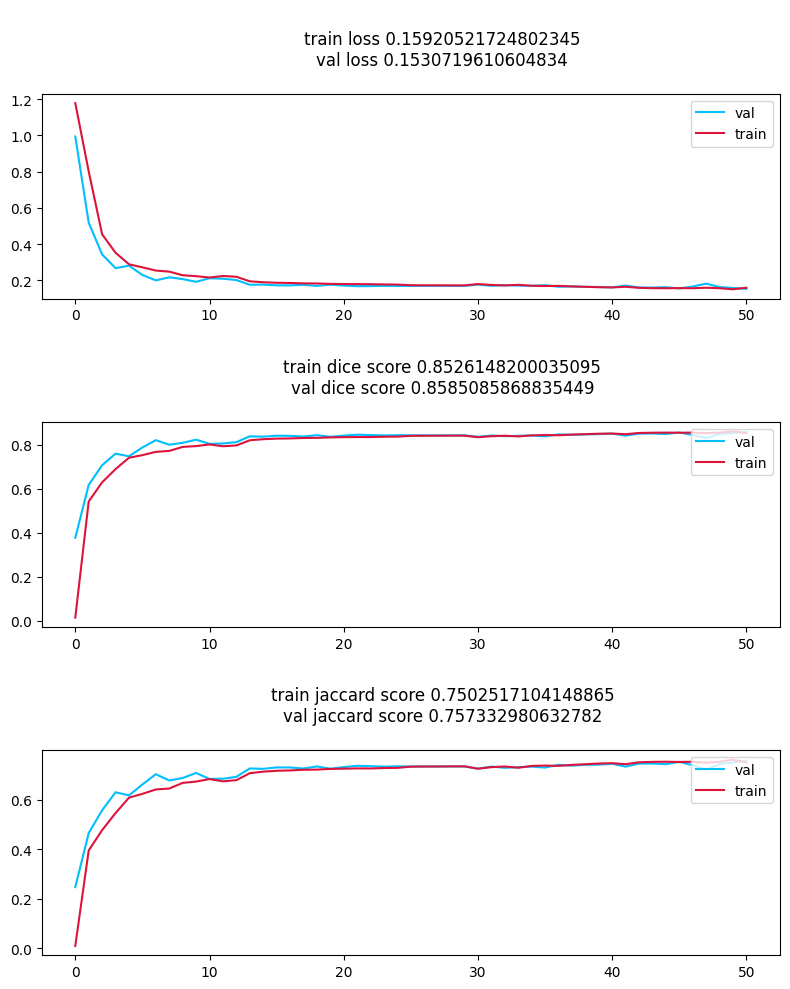


####################
Saved new checkpoint
####################




In [ ]:
# training time(t0) starts
t0 = time.time()
trainer.run()

In [ ]:
# total training time(tt)
t1 = time.time()
tt = t1 - t0
print("Training time : ",tt)

Training time :  1317.0788748264313


In [ ]:
torch.save(nodel.state_dict(), '/content/drive/MyDrive/BraTS/BrainTumorData/unet3d_state_dict.pth')
torch.save(nodel, '/content/drive/MyDrive/BraTS/BrainTumorData/unet3d_model.pth')
gc.collect()

10348

In [ ]:
torch.load('/content/drive/MyDrive/BraTS/BrainTumorData/unet3d_state_dict.pth')
# Loading the serialized model to avoid computation
model = torch.load('/content/drive/MyDrive/BraTS/BrainTumorData/unet3d_model.pth')

# Turning on Evaluation mode of the model
model.eval()

In [ ]:
test_dataloader = get_dataloader(dataset=BratsDataset, path_to_csv='/content/drive/MyDrive/BraTS/BrainTumorData/train_data.csv', phase="valid", fold=1)
len(test_dataloader)

# Print the length of the dataloader
print(len(test_dataloader))

for batch in test_dataloader:
    inputs = batch['image']  # Access the images
    ids = batch['Id']  # Access the IDs if needed
    labels = batch.get('labels', None)
    if labels is not None:
        print(f'Labels shape: {labels.shape}')
    else:
        print("No labels found in the batch.")

    print(f'Inputs shape: {inputs.shape}')
    break  # Print only for the first batch


34
No labels found in the batch.
Inputs shape: torch.Size([1, 4, 155, 240, 240])


In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

gc.collect()
def compute_metrics(model, dataloader, threshold=0.33):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()

    true_positives = 0
    false_positives = 0
    true_negatives = 0
    false_negatives = 0

    counter = 0  # Counter to keep track of the number of entries processed

    with torch.no_grad():  # Disable gradient calculations to save memory
        for data in dataloader:

            images, targets = data['image'], data['mask']
            images = images.to(device)
            targets = targets.to(device)

            logits = model(images)
            probabilities = torch.sigmoid(logits)
            predictions = (probabilities >= threshold).float()

            # Compute binary segmentation metrics
            true_positives += torch.sum((predictions == 1) & (targets == 1)).item()
            false_positives += torch.sum((predictions == 1) & (targets == 0)).item()
            true_negatives += torch.sum((predictions == 0) & (targets == 0)).item()
            false_negatives += torch.sum((predictions == 0) & (targets == 1)).item()

            counter += 1

            # Free memory by clearing intermediate variables
            del images, targets, logits, probabilities, predictions
            torch.cuda.empty_cache()

    return true_positives , false_positives , true_negatives , false_negatives

tp , fp , tn , fn  = compute_metrics(nodel, test_dataloader, threshold=0.33)
print(f"True positives : {tp}")
print(f"False positives : {fp}")
print(f"True Negatives : {tn}")
print(f"False Negatives : {fn}")

True positives : 3601980
False positives : 604679
True Negatives : 905727850
False Negatives : 721491


# Confusion Matrix

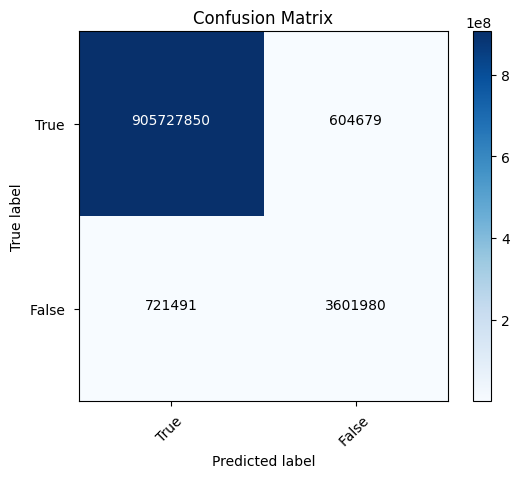

In [ ]:
# Confusion matrix¶
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(tp, fp, tn, fn):
    # Create confusion matrix array
    confusion_matrix = np.array([[tn, fp], [fn, tp]])

    # Set up labels for matrix
    labels = ['True ', 'False ']

    # Create color map
    cmap = plt.cm.Blues

    # Plot confusion matrix
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix')
    plt.colorbar()

    # Add labels to matrix cells
    thresh = confusion_matrix.max() / 2.
    for i, j in np.ndindex(confusion_matrix.shape):
        plt.text(j, i, format(confusion_matrix[i, j], 'd'),
        horizontalalignment='center', color='white' if confusion_matrix[i, j] > thresh else 'black')

    # Set tick labels
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    # Set axis labels
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    # Show plot
    plt.show()

plot_confusion_matrix(tp, fp, tn, fn)


# Evaluation Metrics

In [ ]:
# Evaluation metrics¶
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)
print(f"Accuracy : {accuracy*100}")
print(f"Precision : {precision*100}")
print(f"Recall : {recall*100}")
print(f"F1 Score : {f1_score*100}")





Accuracy : 99.85437201314218
Precision : 85.62567110859234
Recall : 83.31222760601378
F1 Score : 84.45310915542905


In [ ]:
def compute_metrics(model, dataloader, num_entries, threshold=0.33):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    predictions = []
    true_masks = []  # Store ground truth masks

    counter = 0

    with torch.no_grad():
        for data in dataloader:
            if counter >= num_entries:
                break  # Stop processing entries if the desired number is reached

            images, targets = data['image'], data['mask']
            images = images.to(device)
            targets = targets.to(device)

            logits = model(images)
            probabilities = torch.sigmoid(logits)
            prediction = (probabilities >= threshold).float()

            prediction = prediction.cpu()
            targets = targets.cpu()

            predictions.append(prediction)
            true_masks.append(targets)

            model.zero_grad()
            del images, targets, logits, probabilities, prediction
            torch.cuda.empty_cache()

            counter += 1

    # Flatten both y_true and y_pred arrays to be compatible for classification metrics
    y_true = torch.cat(true_masks, dim=0).numpy().flatten()
    y_pred = torch.cat(predictions, dim=0).numpy().flatten()

    print(f'Flattened y_true shape: {y_true.shape}')
    print(f'Flattened y_pred shape: {y_pred.shape}')

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Compute classification report
    class_names = ['Background', 'Tumor']
    report = classification_report(y_true, y_pred, target_names=class_names)

    evaluation_results = {
        'Confusion Matrix': cm,
        'Classification Report': report
    }

    return evaluation_results

num_entries = 5
evaluation_results = compute_metrics(model, test_dataloader, num_entries, threshold=0.33)

# Print the evaluation results
for metric, value in evaluation_results.items():
    print(f'{metric}: {value}')


Flattened y_true shape: (133920000,)
Flattened y_pred shape: (133920000,)
Confusion Matrix: [[133326545     82854]
 [    36558    474043]]
Classification Report:               precision    recall  f1-score   support

  Background       1.00      1.00      1.00 133409399
       Tumor       0.85      0.93      0.89    510601

    accuracy                           1.00 133920000
   macro avg       0.93      0.96      0.94 133920000
weighted avg       1.00      1.00      1.00 133920000



In [ ]:
# Classification Report
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

gc.collect()


def compute_metrics(model, dataloader, num_entries, threshold=0.33):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    predictions = []

    # Counter to keep track of the number of entries processed
    counter = 0

    with torch.no_grad():
        for data in dataloader:
            if counter >= num_entries:
                break  # Stop processing entries if the desired number is reached

            images, targets = data['image'], data['mask']
            images = images.to(device)
            targets = targets.to(device)

            logits = model(images)
            probabilities = torch.sigmoid(logits)
            prediction = (probabilities >= threshold).float()

            prediction =  prediction.cpu()
            targets = targets.cpu()

            predictions.append(prediction)

            model.zero_grad()
            del images, targets, logits, probabilities, prediction
            torch.cuda.empty_cache()

            counter += 1

    # Compute confusion matrix
    y_true = np.concatenate([targets.cpu() for data in dataloader for targets in data['mask']])
    y_pred = np.concatenate([prediction.cpu() for data in dataloader for prediction in predictions])

    # y_true = np.concatenate([targets for targets in dataloader.dataset])
    # y_pred = np.concatenate([predictions for predictions in predictions])

    print(y_true.shape)
    print(y_pred.shape)
    # # Flatten the arrays
    # y_true_flat = y_true.reshape(-1)  # Reshape to 1D
    # y_pred_flat = np.argmax(y_pred, axis=1).reshape(-1)  # Get predicted class for each slice and reshape
    cm = confusion_matrix(y_true, y_pred)

    # Compute classification report
    class_names = ['Background', 'Tumor']
    report = classification_report(y_true, y_pred, target_names=class_names)

    # Return evaluation metrics, confusion matrix, and classification report
    evaluation_results = {
        'Confusion Matrix': cm,
        'Classification Report': report
    }

    return evaluation_results

num_entries = 5  # Specify the number of entries to evaluate
evaluation_results = compute_metrics(nodel, test_dataloader, num_entries, threshold=0.33)

# Print the evaluation results
for metric, value in evaluation_results.items():
    print(f'{metric}: {value}')




# Dice and Jaccard Scores per Classes

In [ ]:
# Experiments and Results
def compute_scores_per_classes(model,          # nodel which is UNeT3D
                               dataloader,     # tuple consisting of ( id , image tensor , mask tensor )
                               classes):       # classes : WT , TC , ET
    """
    Compute Dice and Jaccard coefficients for each class.
    Params:
        model: neural net for make predictions.
        dataloader: dataset object to load data from.
        classes: list with classes.
        Returns: dictionaries with dice and jaccard coefficients for each class for each slice.
    """
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    dice_scores_per_classes = {key: list() for key in classes}
    iou_scores_per_classes = {key: list() for key in classes}

    with torch.no_grad():
        for i, data in enumerate(dataloader):
            imgs, targets = data['image'], data['mask']
            imgs, targets = imgs.to(device), targets.to(device)
            logits = model(imgs)
            logits = logits.detach().cpu().numpy()
            targets = targets.detach().cpu().numpy()

            # Now finding the overlap between the raw prediction i.e. logit & the mask i.e. target & finding the dice & iou scores
            dice_scores = dice_coef_metric_per_classes(logits, targets)
            iou_scores = jaccard_coef_metric_per_classes(logits, targets)

            # storing both dice & iou scores in the list declared
            for key in dice_scores.keys():
                dice_scores_per_classes[key].extend(dice_scores[key])

            for key in iou_scores.keys():
                iou_scores_per_classes[key].extend(iou_scores[key])

    return dice_scores_per_classes, iou_scores_per_classes
val_dataloader = get_dataloader(BratsDataset, '/content/drive/MyDrive/BraTS/BrainTumorData/train_data.csv', phase='valid', fold=0)
len(dataloader)

34

In [ ]:
model.eval();
# %%time
dice_scores_per_classes, iou_scores_per_classes = compute_scores_per_classes(
    nodel, val_dataloader, ['WT', 'TC', 'ET']
    )

In [ ]:
dice_df = pd.DataFrame(dice_scores_per_classes)
dice_df.columns = ['WT dice', 'TC dice', 'ET dice']

iou_df = pd.DataFrame(iou_scores_per_classes)
iou_df.columns = ['WT jaccard', 'TC jaccard', 'ET jaccard']
# CONCAT BOTH THE COLUMNS ALONG AXIS 1 & SORT THE TWO
val_metics_df = pd.concat([dice_df, iou_df], axis=1, sort=True)
val_metics_df = val_metics_df.loc[:, ['WT dice', 'WT jaccard',
                                      'TC dice', 'TC jaccard',
                                      'ET dice', 'ET jaccard']]
val_metics_df.sample(5)

WT dice  WT jaccard   TC dice  TC jaccard   ET dice  ET jaccard
4   0.740107    0.587436  0.701638    0.540403  0.855956    0.748185
9   0.892141    0.805285  0.801740    0.669087  0.882069    0.789019
27  0.921876    0.855074  0.854786    0.746398  0.826659    0.704534
2   0.969126    0.940101  0.651884    0.483552  0.652195    0.483894
20  0.832577    0.713175  0.376179    0.231663  0.232602    0.131607

In [ ]:
colors = ['#35FCFF', '#FF355A', '#96C503', '#C5035B', '#28B463', '#35FFAF']
palette = sns.color_palette(colors, 6)

fig, ax = plt.subplots(figsize=(12, 6));
sns.barplot(x=val_metics_df.mean().index, y=val_metics_df.mean(), palette=palette, ax=ax);
ax.set_xticklabels(val_metics_df.columns, fontsize=14, rotation=15);
ax.set_title("Dice and Jaccard Coefficients from Validation", fontsize=20)

for idx, p in enumerate(ax.patches):
        percentage = '{:.1f}%'.format(100 * val_metics_df.mean().values[idx])
        x = p.get_x() + p.get_width() / 2 - 0.15
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), fontsize=15, fontweight="bold")

fig.savefig("result1.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
fig.savefig("result1.svg", format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')

In [ ]:
# Computing the brain tumour segmented masks¶
def compute_results(model,
                    dataloader,
                    treshold=0.33):

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    results = {"Id": [],"image": [], "GT": [],"Prediction": []}

    with torch.no_grad():
        for i, data in enumerate(dataloader):
            id_, imgs, targets = data['Id'], data['image'], data['mask']
            imgs, targets = imgs.to(device), targets.to(device)
            logits = model(imgs)
            probs = torch.sigmoid(logits)

            predictions = (probs >= treshold).float()
            predictions =  predictions.cpu()
            targets = targets.cpu()

            results["Id"].append(id_)
            results["image"].append(imgs.cpu())
            results["GT"].append(targets)
            results["Prediction"].append(predictions)

            # only 5 pars
            if (i > 5):
                return results
        return results
# prediction time starts(p0)
p0 = time.time()
results = compute_results(
    nodel, val_dataloader, 0.33)
# total prediction time(pt)
p1 = time.time()
pt = p1 - p0
print("Model prediction time ; ",pt )

for id_, img, gt, prediction in zip(results['Id'][4:],
                    results['image'][4:],
                    results['GT'][4:],
                    results['Prediction'][4:]
                    ):

    print(id_)
    break

Model prediction time ;  11.000314235687256
['BraTS20_Training_003']


In [ ]:
# Visualizing the predicted segmented masks¶
show_result = ShowResult()
show_result.plot(img, gt, prediction)

# 3D SCATTER PLOT OF THE BRAIN TUMOUR WITH :
## 1. necrotic and non-enhancing tumor core (NCR/NET — label 1)
## 2. peritumoral edema (ED — label 2)
## 3. GD-enhancing tumor (ET — label 4)¶

In [ ]:
class ImageReader:
    def __init__(self, root:str, img_size:int=256, normalize:bool=False, single_class:bool=False):
        pad_size = 256 if img_size > 256 else 224
        self.resize = A.Compose(
            [
                A.PadIfNeeded(min_height=pad_size, min_width=pad_size, value=0),
                A.Resize(img_size, img_size)
            ]
        )
        self.normalize=normalize
        self.single_class=single_class
        self.root=root

    def read_file(self, path:str) -> dict:
        scan_type = path.split('_')[-1]
        raw_image = nib.load(path).get_fdata()
        raw_mask = nib.load(path.replace(scan_type, 'seg.nii')).get_fdata()
        processed_frames, processed_masks = [], []
        for frame_idx in range(raw_image.shape[2]):
            frame = raw_image[:, :, frame_idx]
            mask = raw_mask[:, :, frame_idx]
            if self.normalize:
                if frame.max() > 0:
                    frame = frame/frame.max()
                frame = frame.astype(np.float32)
            else:
                frame = frame.astype(np.uint8)
            resized = self.resize(image=frame, mask=mask)
            processed_frames.append(resized['image'])
            processed_masks.append(1*(resized['mask'] > 0) if self.single_class else resized['mask'])
        return {
            'scan': np.stack(processed_frames, 0),
            'segmentation': np.stack(processed_masks, 0),
            'orig_shape': raw_image.shape
        }

    def load_patient_scan(self, idx:int, scan_type:str='flair') -> dict:
        patient_id = str(1).zfill(3)
        scan_filename = f'{self.root}/BraTS20_Training_{patient_id}/BraTS20_Training_{patient_id}_{scan_type}.nii'
        return self.read_file(scan_filename)

import plotly.graph_objects as go
import numpy as np
import plotly


def generate_3d_scatter(
    x:np.array, y:np.array, z:np.array, colors:np.array,
    size:int=3, opacity:float=0.2, scale:str='Teal',
    hover:str='skip', name:str='MRI'
) -> go.Scatter3d:
    return go.Scatter3d(
        x=x, y=y, z=z,
        mode='markers', hoverinfo=hover,
        marker = dict(
            size=size, opacity=opacity,
            color=colors, colorscale=scale
        ),
        name=name
    )


class ImageViewer3d():
    def __init__(
        self, reader:ImageReader, mri_downsample:int=10, mri_colorscale:str='Ice'
    ) -> None:
        self.reader = reader
        self.mri_downsample = mri_downsample
        self.mri_colorscale = mri_colorscale

    def load_clean_mri(self, image:np.array, orig_dim:int) -> dict:
        shape_offset = image.shape[1]/orig_dim
        z, x, y = (image > 0).nonzero()
        # only (1/mri_downsample) is sampled for the resulting image
        x, y, z = x[::self.mri_downsample], y[::self.mri_downsample], z[::self.mri_downsample]
        colors = image[z, x, y]
        return dict(x=x/shape_offset, y=y/shape_offset, z=z, colors=colors)
    def load_tumor_segmentation(self, image:np.array, orig_dim:int) -> dict:
        tumors = {}
        shape_offset = image.shape[1]/orig_dim
        # 1/1, 1/3 si 1/5 pixeli pentru clasele tumorii  1(nucleu necrotic), 2(edem) si 4(tumoare de amplificare)
        sampling = {
            1: 1, 2: 3, 4: 5
        }
        for class_idx in sampling:
            z, x, y = (image == class_idx).nonzero()
            x, y, z = x[::sampling[class_idx]], y[::sampling[class_idx]], z[::sampling[class_idx]]
            tumors[class_idx] = dict(
                x=x/shape_offset, y=y/shape_offset, z=z,
                colors=class_idx/4
            )
        return tumors
    def collect_patient_data(self, scan:dict) -> tuple:
        clean_mri = self.load_clean_mri(scan['scan'], scan['orig_shape'][0])
        tumors = self.load_tumor_segmentation(scan['segmentation'], scan['orig_shape'][0])
        markers_created = clean_mri['x'].shape[0] + sum(tumors[class_idx]['x'].shape[0] for class_idx in tumors)
        return [
            generate_3d_scatter(**clean_mri, scale=self.mri_colorscale, opacity=0.3, hover='skip', name='Brain MRI'),
            generate_3d_scatter(**tumors[1], opacity=0.90, hover='all', name='Necrotic tumor core'),
            generate_3d_scatter(**tumors[2], opacity=0.05, hover='all', name='Peritumoral invaded tissue'),
            generate_3d_scatter(**tumors[4], opacity=0.30, hover='all', name='GD-enhancing tumor'),
        ], markers_created
    def get_3d_scan(self, patient_idx:int, scan_type:str='flair') -> go.Figure:
        scan = self.reader.load_patient_scan(patient_idx, scan_type)
        data, num_markers = self.collect_patient_data(scan)
        fig = go.Figure(data=data)
        fig.update_layout(
            title=f"[Patient id:{patient_idx}] brain MRI scan ({num_markers} points)",
            legend_title="Pixel class (click to enable/disable)",
            font=dict(
                family="Courier New, monospace",
                size=14,
            ),
            margin=dict(
                l=0,r=0,b=0,t=30
            ),
            legend=dict(itemsizing='constant')
        )
        return fig

# tumour visualization time starts(tv0)
tv0 = time.time()
reader = ImageReader(config.train_root_dir, img_size=128, normalize=True, single_class=False)
viewer = ImageViewer3d(reader, mri_downsample=25)

fig = viewer.get_3d_scan(250, 'flair')
plotly.offline.iplot(fig)

In [ ]:
# total tumour visualization time(tvt)
tv1 = time.time()
tvt = tv1 - tv0
print("3D Scatter plot time : ", tvt )

3D Scatter plot time :  112.17551708221436


In [ ]:
# import plotly.offline as pyo
# import plotly.graph_objects as go

# # Save the scatter plot as an image file
# filename = '/content/drive/MyDrive/BraTS/BrainTumorData/scatter_plot.png'  # Replace with your desired file path
# pyo.plot(fig, filename=filename, auto_open=False)

import plotly.io as pio
!pip install kaleido

# Generate the 3D scatter plot as before
fig = viewer.get_3d_scan(250, 'flair')

# Specify the file path and format (PNG, PDF, JPEG, etc.)
output_file_path = '/content/drive/MyDrive/BraTS/BrainTumorData/3d_scatter_plot.png'  # Save as a PNG

# Save the figure
# pio.write_image(fig, output_file_path)
pio.write_image(fig, output_file_path, width=800, height=600, scale=2)

In [ ]:
# total code wall time(cwt)
cw1 = time.time()
cwt = cw1 - cw0
print("Total code wall time / running time : ", cwt )

Total code wall time / running time :  33.42189884185791


In [ ]:
# Code running time evalution¶
from tabulate import tabulate

# Define the variables and their respective values
variables = ['Data loading', 'data preprocessing', 'Stratification', 'Model training', 'tumour predction', 'tumour visualization', ' total code wall time']
tt = 1317.0788748264313
values = [dlt, dppt, skft, tt, pt, tvt, cwt]  # Assign the actual values to these variables

# Create a list of lists containing the variables and values
table_data = [[var, val] for var, val in zip(variables, values)]

# Specify the table headers
headers = ['Times', 'Value']

# Generate the table using tabulate
table = tabulate(table_data, headers, tablefmt='grid')

# Print the table
print(table)

+----------------------+------------+
| Times                |      Value |
+======================+============+
| Data loading         |    4.19044 |
+----------------------+------------+
| data preprocessing   |   28.9949  |
+----------------------+------------+
| Stratification       |    1.94057 |
+----------------------+------------+
| Model training       | 1317.08    |
+----------------------+------------+
| tumour predction     |   10.6911  |
+----------------------+------------+
| tumour visualization |  112.176   |
+----------------------+------------+
| total code wall time |   33.4219  |
+----------------------+------------+


In [ ]:
import matplotlib.pyplot as plt

# Define the variables and their respective values (running times)
variables = ['Data loading', 'data preprocessing', 'Stratification', 'Model training', 'tumour predction', 'tumour visualization', ' total code wall time']
values = [dlt, dppt, skft, tt, pt, tvt, cwt]  # Assign the actual running times to these variables

# Create a bar chart
plt.figure(figsize=(10, 6))  # Set the figure size
plt.bar(variables, values)  # Plot the bar chart

# Add labels and title
plt.xlabel('Variables')  # X-axis label
plt.ylabel('Running Time')  # Y-axis label
plt.title('Running Times of Variables')  # Chart title

# Display the bar chart
plt.show()


In [ ]:
# 3D BINARY MASK GIF PROJECTION¶
# GROUND TRUTH

# gt = gt.squeeze().cpu().detach().numpy()
# gt = np.moveaxis(gt, (0, 1, 2, 3), (0, 3, 2, 1))
# wt,tc, et = gt
# print(wt.shape, tc.shape, et.shape)

# Check if 'gt' is a PyTorch tensor and convert to NumPy if it is
if isinstance(gt, torch.Tensor):  # Check if gt is a tensor
    gt = gt.squeeze().cpu().detach().numpy()  # Convert to NumPy array
else:
    gt = gt.squeeze()  # It's already a NumPy array, just squeeze

# Move axes for the GT array
gt = np.moveaxis(gt, (0, 1, 2, 3), (0, 3, 2, 1))
wt, tc, et = gt  # Separate classes
print(wt.shape, tc.shape, et.shape)

gt = (wt + tc + et)
gt = np.clip(gt, 0, 1)
print(gt.shape)
# %%time
title = "Ground Truth_" + id_[0]
filename1 = title + "_3d.gif"

data_to_3dgif = Image3dToGIF3d(img_dim = (120, 120, 78), binary=True, normalizing=False)
transformed_data = data_to_3dgif.get_transformed_data(gt)
data_to_3dgif.plot_cube(
    transformed_data,
    title=title,
    make_gif=True,
    path_to_save=filename1
)
#show_gif(filename1, format='png')


# PREDICTION
prediction = prediction.squeeze().cpu().detach().numpy()
prediction = np.moveaxis(prediction, (0, 1, 2, 3), (0, 3, 2, 1))
wt,tc,et = prediction
print(wt.shape, tc.shape, et.shape)
prediction = (wt + tc + et)
prediction = np.clip(prediction, 0, 1)
print(prediction.shape)
# %%time
title = "Prediction_" + id_[0]
filename2 = title + "_3d.gif"

data_to_3dgif = Image3dToGIF3d(img_dim = (120, 120, 78), binary=True, normalizing=False)
transformed_data = data_to_3dgif.get_transformed_data(prediction)
data_to_3dgif.plot_cube(
    transformed_data,
    title=title,
    make_gif=True,
    path_to_save=filename2
)
#show_gif(filename2, format='png')#


# RESULT
merging_two_gif(filename1,
                filename2,
                'result.gif')
show_gif('result.gif', format='png')
import shutil

shutil.make_archive('/content/drive/MyDrive/BraTS/BrainTumorData/Output_Files', 'zip', '/content/drive/MyDrive/BraTS/BrainTumorData/')

AxisError: source: axis 3 is out of bounds for array of dimension 3

In [ ]:
import numpy as np
import torch

# Assuming `gt` and `prediction` are your tensors
# Check if 'gt' is a PyTorch tensor and convert to NumPy if it is
if isinstance(gt, torch.Tensor):
    gt = gt.squeeze().cpu().detach().numpy()  # Convert to NumPy array
else:
    gt = gt.squeeze()  # It's already a NumPy array, just squeeze

# Check dimensions of `gt` before moving axes
print("GT shape after squeeze:", gt.shape)

# If `gt` has shape (3, D, H, W), it's 4D, so `np.moveaxis` can be applied.
# Otherwise, adjust according to its actual shape.
if gt.ndim == 4:
    gt = np.moveaxis(gt, (0, 1, 2, 3), (0, 3, 2, 1))
elif gt.ndim == 3:
    print("GT already has 3 dimensions; skipping axis move.")

# Separate classes if it's 4D, else handle accordingly
if gt.ndim == 4:
    wt, tc, et = gt  # Separate classes
    print("Shapes:", wt.shape, tc.shape, et.shape)
else:
    wt, tc, et = gt, np.zeros_like(gt), np.zeros_like(gt)  # Default if only 3D

# Combine classes
gt = (wt + tc + et)
gt = np.clip(gt, 0, 1)
print("Combined GT shape:", gt.shape)
print("Data type of GT:", gt.dtype)  # Check the data type


gt_normalized = (gt - gt.min()) / (gt.max() - gt.min()) * 255  # Normalize to 0-255
gt_normalized = gt_normalized.astype(np.uint8)  # Convert to uint8


GT shape after squeeze: (240, 240, 155)
GT already has 3 dimensions; skipping axis move.
Combined GT shape: (240, 240, 155)
Data type of GT: float32


In [ ]:
# Proceed with 3D scatter plot generation
title = "Ground Truth_" + id_[0]
viewer = ImageViewer3d(reader, mri_downsample=25)

# Get the 3D scatter plot for the specified patient and scan type
fig = viewer.get_3d_scan(id_[0], 'flair')

# Update the layout to include the title
fig.update_layout(title=title)

# Display the figure
plotly.offline.iplot(fig)
import plotly.io as pio

# Save the figure as an HTML file
pio.write_html(fig, '/content/drive/MyDrive/BraTS/BrainTumorData/groundtruth.html')

In [ ]:
# Prediction part
if isinstance(prediction, torch.Tensor):
    prediction = prediction.squeeze().cpu().detach().numpy()  # Convert to NumPy array
else:
    prediction = prediction.squeeze()  # It's already a NumPy array, just squeeze

# prediction = prediction.squeeze().cpu().detach().numpy()
# print("Prediction shape after squeeze:", prediction.shape)

if prediction.ndim == 4:
    prediction = np.moveaxis(prediction, (0, 1, 2, 3), (0, 3, 2, 1))
elif prediction.ndim == 3:
    print("Prediction already has 3 dimensions; skipping axis move.")

if prediction.ndim == 4:
    wt, tc, et = prediction
    print("Prediction shapes:", wt.shape, tc.shape, et.shape)
else:
    wt, tc, et = prediction, np.zeros_like(prediction), np.zeros_like(prediction)

prediction = (wt + tc + et)
prediction = np.clip(prediction, 0, 1)
print("Combined Prediction shape:", prediction.shape)



Prediction already has 3 dimensions; skipping axis move.
Combined Prediction shape: (240, 240, 155)


In [ ]:
prediction_normalized = (prediction_combined - prediction_combined.min()) / (prediction_combined.max() - prediction_combined.min()) * 255  # Normalize to 0-255
prediction_normalized = prediction_normalized.astype(np.uint8)  # Convert to uint8

# Proceed with 3D scatter plot generation for prediction
title_pred = "Prediction_" + id_[0]
viewer_pred = ImageViewer3d(reader, mri_downsample=25)

# Get the 3D scatter plot for the specified patient and scan type for prediction
fig_pred = viewer_pred.get_3d_scan(id_[0], 'flair')
fig_pred.update_layout(title=title_pred)

# Display the prediction figure
plotly.offline.iplot(fig_pred)
import plotly.io as pio

# Save the figure as an HTML file
pio.write_html(fig_pred, '/content/drive/MyDrive/BraTS/BrainTumorData/predictions.html')

In [ ]:
import plotly.offline as pyo
# Combine both plots into a single figure
fig_combined = go.Figure()

# Add ground truth scatter plot
gt_x, gt_y, gt_z = np.where(gt > 0)  # Get coordinates of ground truth points
fig_combined.add_trace(go.Scatter3d(
    x=gt_x,
    y=gt_y,
    z=gt_z,
    mode='markers',
    marker=dict(size=2, color='blue', opacity=0.5),
    name='Ground Truth'
))

# Add prediction scatter plot
pred_x, pred_y, pred_z = np.where(prediction_combined > 0)  # Get coordinates of prediction points
fig_combined.add_trace(go.Scatter3d(
    x=pred_x,
    y=pred_y,
    z=pred_z,
    mode='markers',
    marker=dict(size=2, color='red', opacity=0.5),
    name='Prediction'
))

# Update layout
fig_combined.update_layout(
    title='Ground Truth and Prediction Comparison',
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis'
    )
)

# Display the combined figure
pyo.iplot(fig_combined)

In [ ]:
import numpy as np
import torch
import plotly.offline as pyo
import plotly.graph_objects as go

# Assuming `id_`, `reader`, `gt`, and `prediction` are defined in your context

# Function to process and normalize data
def process_data(data):
    if isinstance(data, torch.Tensor):
        data = data.squeeze().cpu().detach().numpy()  # Convert to NumPy array
    else:
        data = data.squeeze()  # It's already a NumPy array, just squeeze

    # Create masks for each class
    wt = (data == 1).astype(np.float32)  # White Matter
    tc = (data == 2).astype(np.float32)  # Tumor Core
    et = (data == 3).astype(np.float32)  # Enhancing Tumor

    # Combine and clip the masks
    combined = np.clip(wt + tc + et, 0, 1)

    return combined

# Process ground truth and prediction
gt_combined = process_data(gt)
prediction_combined = process_data(prediction)

# Get coordinates for ground truth
gt_x, gt_y, gt_z = np.where(gt_combined > 0)

# Get coordinates for predictions
pred_x, pred_y, pred_z = np.where(prediction_combined > 0)

# Create a viewer for the 3D brain scan
title = "Brain Scan - " + id_[0]
viewer = ImageViewer3d(reader, mri_downsample=25)

# Get the 3D scan for the specified patient and scan type
fig_brain = viewer.get_3d_scan(id_[0], 'flair')

# Add ground truth scatter plot
fig_brain.add_trace(go.Scatter3d(
    x=gt_x,
    y=gt_y,
    z=gt_z,
    mode='markers',
    marker=dict(size=2, color='blue', opacity=0.5),
    name='Ground Truth'
))

# Add prediction scatter plot
fig_brain.add_trace(go.Scatter3d(
    x=pred_x,
    y=pred_y,
    z=pred_z,
    mode='markers',
    marker=dict(size=2, color='red', opacity=0.5),
    name='Prediction'
))

# Update layout
fig_brain.update_layout(
    title=title,
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis'
    )
)

# Display the combined figure with the brain scan and overlays
pyo.iplot(fig_brain)
import plotly.io as pio

# Save the figure as an HTML file
pio.write_html(fig_brain, 'brain_scan_with_predictions.html')



In [ ]:
import numpy as np
import torch
import plotly.offline as pyo
import plotly.graph_objects as go

# Assuming `gt` and `prediction` are your tensors

# Function to convert tensor to numpy and create binary masks
def process_data(data):
    if isinstance(data, torch.Tensor):
        data = data.squeeze().cpu().detach().numpy()  # Convert to NumPy array
    else:
        data = data.squeeze()  # It's already a NumPy array, just squeeze

    # Create masks for each class
    wt = (data == 1).astype(np.float32)  # White Matter
    tc = (data == 2).astype(np.float32)  # Tumor Core
    et = (data == 3).astype(np.float32)  # Enhancing Tumor

    # Combine and clip the masks
    combined = np.clip(wt + tc + et, 0, 1)

    return combined

# Process ground truth and prediction
gt_combined = process_data(gt)
prediction_combined = process_data(prediction)

# Combine both plots into a single figure
fig_combined = go.Figure()

# Add ground truth scatter plot
gt_x, gt_y, gt_z = np.where(gt_combined > 0)  # Get coordinates of ground truth points
fig_combined.add_trace(go.Scatter3d(
    x=gt_x,
    y=gt_y,
    z=gt_z,
    mode='markers',
    marker=dict(size=2, color='blue', opacity=0.5),
    name='Ground Truth'
))

# Add prediction scatter plot
pred_x, pred_y, pred_z = np.where(prediction_combined > 0)  # Get coordinates of prediction points
fig_combined.add_trace(go.Scatter3d(
    x=pred_x,
    y=pred_y,
    z=pred_z,
    mode='markers',
    marker=dict(size=2, color='red', opacity=0.5),
    name='Prediction'
))

# Update layout
fig_combined.update_layout(
    title='Ground Truth and Prediction Comparison',
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis'
    )
)

# Display the combined figure
pyo.iplot(fig_combined)
